<H3>Effects of market movements + liquidity add on LRNA price</H3>
In this notebook, we look at the effects on LRNA price when liquidity is removed during a temporary price move. That is, we set the prices of the assets, then add a large amount of liquidity (currently at 10% of the entire Omnipool TVL), then move the market up or down, then withdraw the liquidity right at the peak of the price move. We then move the market back to where it began and observe the difference in LRNA price between the starting and ending conditions.

Starting simulation...
Execution time: 0.09 seconds.


<H3>Omnipool dynamics when liquidity is removed during a temporary price move of -90%</H3>

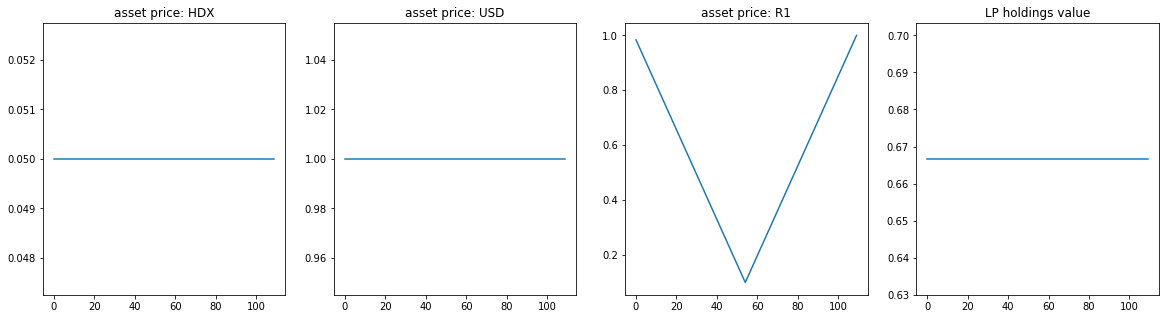

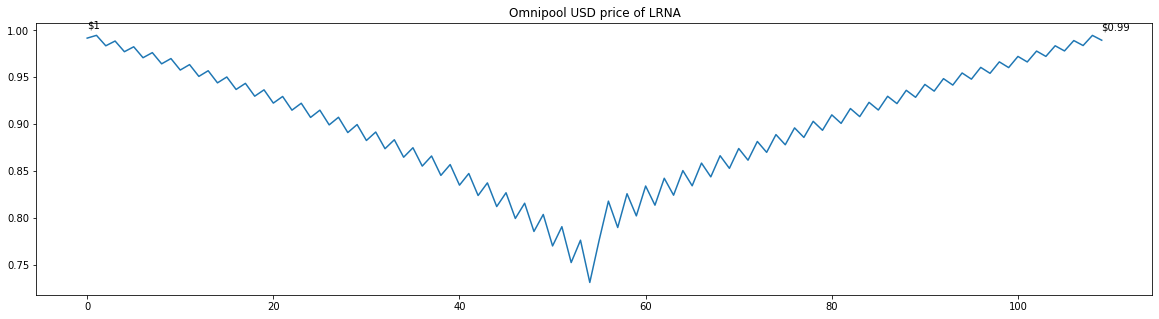

Starting simulation...
Execution time: 0.127 seconds.


<H3>Omnipool dynamics when liquidity is removed during a temporary price move of -50%</H3>

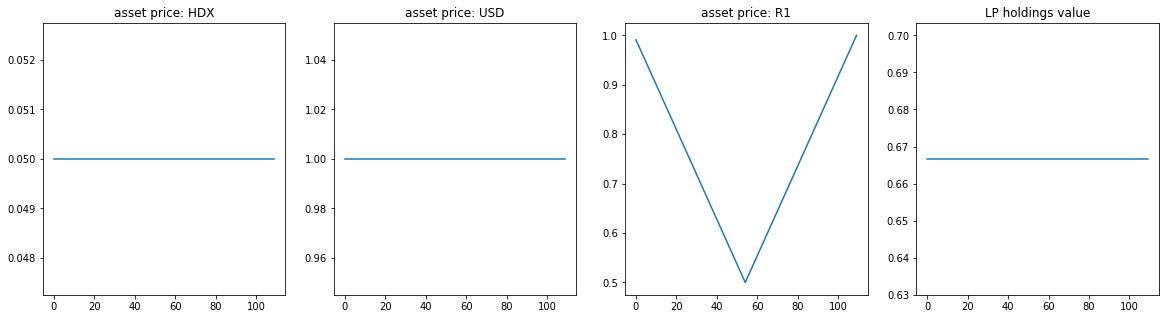

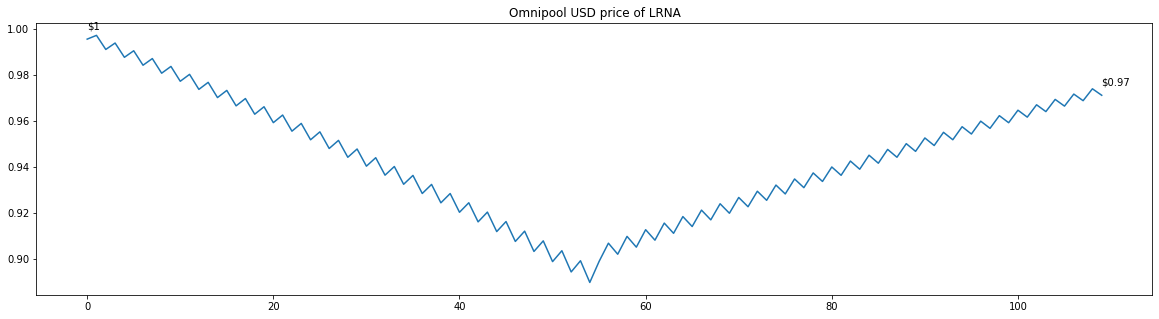

Starting simulation...
Execution time: 0.096 seconds.


<H3>Omnipool dynamics when liquidity is removed during a temporary price move of +100%</H3>

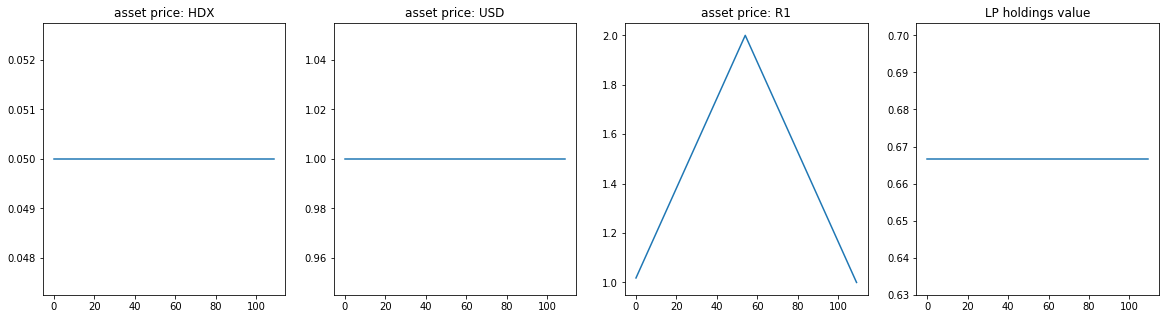

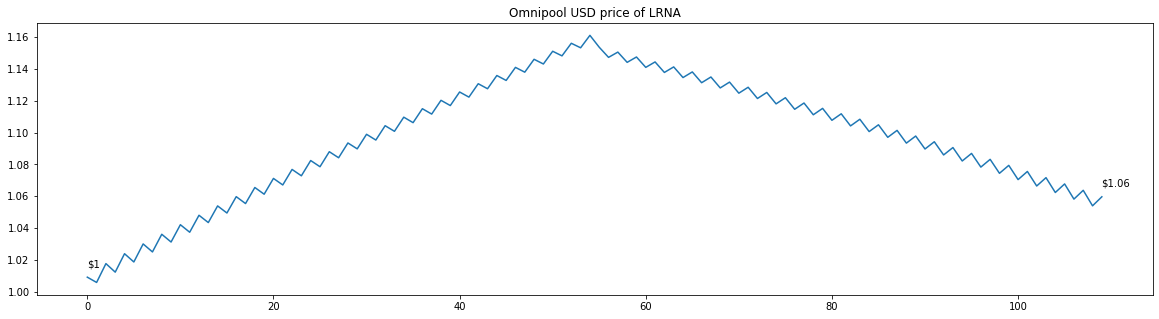

Starting simulation...
Execution time: 0.14 seconds.


<H3>Omnipool dynamics when liquidity is removed during a temporary price move of +900%</H3>

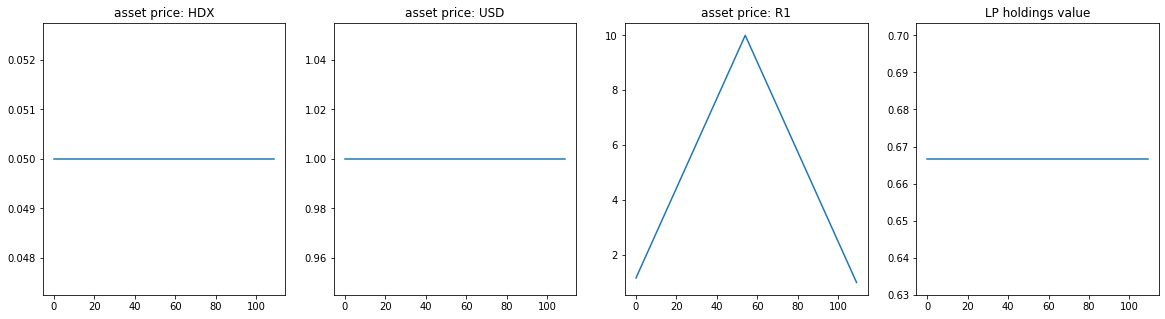

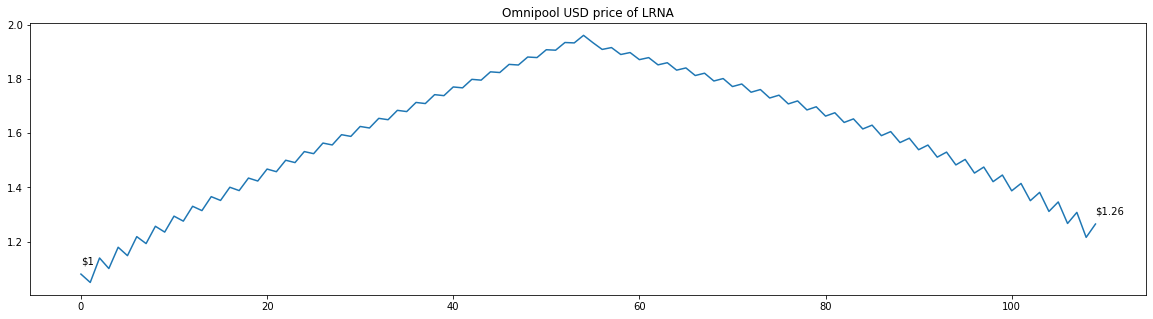

In [11]:
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, lrna_price, usd_price
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, withdraw_all
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from IPython.display import display, Markdown

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.10},
    'R1': {'usd price': 1, 'weight': 0.10},
    'R2': {'usd price': 2/3, 'weight': 0.70},
}

lrna_price_usd = 1
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

%matplotlib inline

price_moves = {0.1: '-90%', 0.5: '-50%', 2: '+100%', 10: '+900%'}
price_move_assets = ['R1']
time_steps = 110
for pump_factor in price_moves:
    for tkn, info in assets.items():
        liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
        lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

    initial_state = GlobalState(
        pools={
            'omnipool': OmnipoolState(
                tokens={
                    tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
                },
                lrna_fee=0.0005,
                asset_fee=0.0025
            )
        },
        agents = {
            'Arbitrageur': Agent(
                holdings={tkn: 10000000000 for tkn in list(assets.keys()) + ['LRNA']},
                trade_strategy=omnipool_arbitrage(
                    pool_id='omnipool',
                    arb_precision=1
                )
            ),
            'LP': Agent(
                holdings={'R1': 1000000},
                trade_strategy=invest_all(
                    pool_id='omnipool'
                ) + withdraw_all(time_steps/2)
            )
        },
        evolve_function=historical_prices(price_list=[
            {
                tkn: assets[tkn]['usd price'] * (pump_factor - (abs(i * 2 - time_steps) / time_steps * (pump_factor - 1)))
                for tkn in price_move_assets
            } 
            for i in range(time_steps + 1)
        ]),
        external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
    )
    events = run.run(initial_state, time_steps=time_steps)
    
    display(Markdown(f"<H3>Omnipool dynamics when liquidity is removed during a temporary price move of {price_moves[pump_factor]}</H3>"))

    pu.plot(events, asset='all')
    # plt.figure(figsize=(20, 5))
    # plt.plot(
    #     range(time_steps), 
    #     [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in events]
    # )
    plt.title('LP holdings value')
    # pu.plot(events, pool='omnipool', prop='lrna')
    # pu.plot(events, pool='omnipool', prop='liquidity')
    # pu.plot(events, pool='omnipool', prop='usd_price', key=['R1', 'R2', 'HDX', 'USD'])
    plt.figure(figsize=(20, 5))
    plt.plot(range(len(events)), [1 / x for x in pu.get_datastream(events, pool='omnipool', prop='lrna_price', key='USD')])
    plt.title("Omnipool USD price of LRNA")
    plt.annotate(
        str(f"${lrna_price_usd}"), 
        xy=(0, 1 / lrna_price(events[0].pools['omnipool'], 'USD')), 
        xytext=(0,10), 
        textcoords='offset points'
    )
    plt.annotate(
        str(f"${round(1 / lrna_price(events[-1].pools['omnipool'], 'USD'), 2)}"), 
        xy=(len(events), 1 / lrna_price(events[-1].pools['omnipool'], 'USD')), 
        xytext=(-10,10), 
        textcoords='offset points'
    )
    plt.show()

# events = processing.postprocessing(events, optional_params=['withdraw_val'])